<a href="https://colab.research.google.com/github/davyandr/pet-projects/blob/main/ab/ab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! gdown 1h7jgAZxYRgBN-pJCfIUyqPZlryKMK_N_

https://drive.google.com/file/d/1h7jgAZxYRgBN-pJCfIUyqPZlryKMK_N_/view?usp=sharing

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats as ss
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

In [5]:
df = pd.read_csv('/content/AB_testing_exercise.csv')
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,GRP B,I
1,11122053,USA,M,498,2,2017-07-14,GRP B,I
2,11128688,USA,F,2394,6,2017-09-17,GRP A,I
3,11130578,USA,F,1197,3,2017-11-30,GRP A,I
4,11130759,ESP,M,1297,3,2018-01-10,GRP B,A


In [8]:
df.group = df.group.apply(lambda x: 'control' if x == 'GRP A' else 'variant')

In [10]:
df.head()

,uid,country,gender,spent,purchases,date,group,device
0,11115722,MEX,F,1595,5,2016-03-08,variant,I
1,11122053,USA,M,498,2,2017-07-14,variant,I
2,11128688,USA,F,2394,6,2017-09-17,control,I
3,11130578,USA,F,1197,3,2017-11-30,control,I
4,11130759,ESP,M,1297,3,2018-01-10,variant,A


In [9]:
df.uid.nunique() / df.shape[0]

1.0

Сheck that the device, gender are equally distributed in the samples

In [14]:
pd.pivot_table(data=df, index='group', columns=['gender', 'device'], values='uid', aggfunc=len)

gender      F           M      
device      A     I     A     I
group                          
control  5616  5755  5871  5767
variant  5760  5636  5735  5743

## Choosing metrics

* count of purchases
* aov
* spent

In [19]:
df['aov'] = (df.spent / df.purchases)

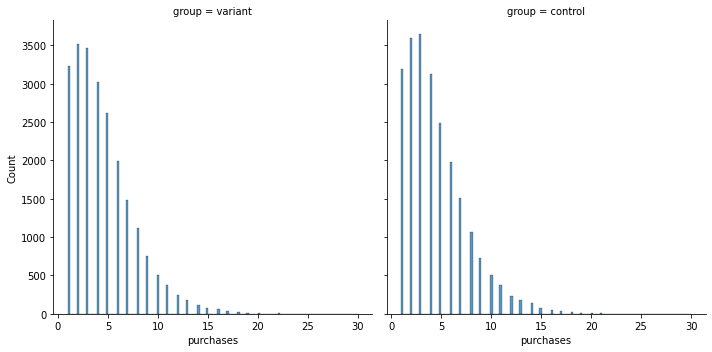

In [26]:
sns.displot(data=df, x='purchases', col='group');

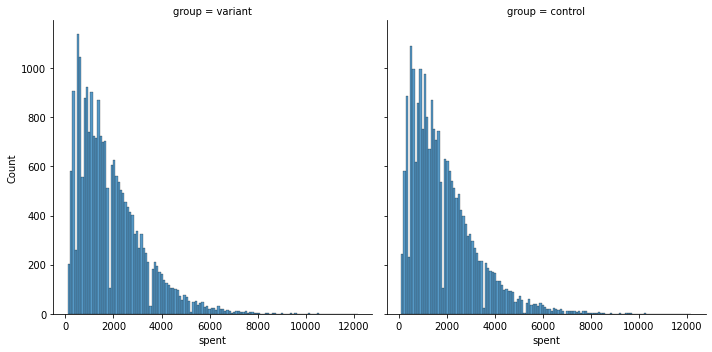

In [28]:
sns.displot(data=df, x='spent', col='group');

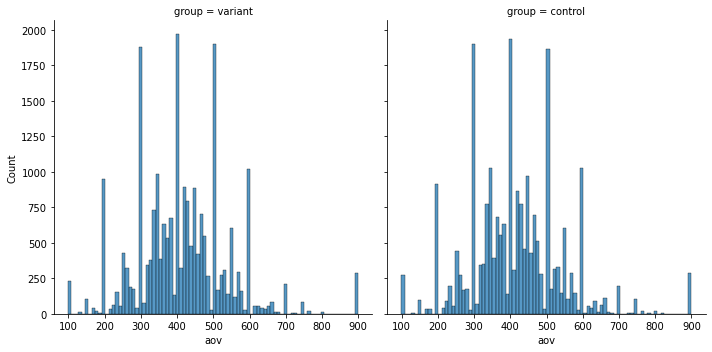

In [30]:
sns.displot(data=df, x='aov', col='group');

##Mann-Whitneyu

In [38]:
#spent
sample1 = df[df['group'] == 'control'].spent
sample2 = df[df['group'] == 'variant'].spent

In [37]:
mw = round(ss.mannwhitneyu(sample1, sample2)[1], 3)

print('Mann_Whitneyu, p_value =', mw, (', p_value > 0.05, +' if mw > 0.05 else ", p_value <= 0.05, -"))

Mann_Whitneyu, p_value = 0.45 , p_value > 0.05, +


In [39]:
#aov
sample1 = df[df['group'] == 'control'].aov
sample2 = df[df['group'] == 'variant'].aov

In [40]:
mw = round(ss.mannwhitneyu(sample1, sample2)[1], 3)

print('Mann_Whitneyu, p_value =', mw, (', p_value > 0.05, +' if mw > 0.05 else ", p_value <= 0.05, -"))

Mann_Whitneyu, p_value = 0.975 , p_value > 0.05, +


In [41]:
#purchases
sample1 = df[df['group'] == 'control'].purchases
sample2 = df[df['group'] == 'variant'].purchases

In [42]:
mw = round(ss.mannwhitneyu(sample1, sample2)[1], 3)

print('Mann_Whitneyu, p_value =', mw, (', p_value > 0.05, +' if mw > 0.05 else ", p_value <= 0.05, -"))

Mann_Whitneyu, p_value = 0.359 , p_value > 0.05, +


## Bootstrap

In [43]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    from scipy.stats import zscore, norm
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [44]:
#spent
sample1 = df[df['group'] == 'control'].spent
sample2 = df[df['group'] == 'variant'].spent

  0%|          | 0/5000 [00:00<?, ?it/s]

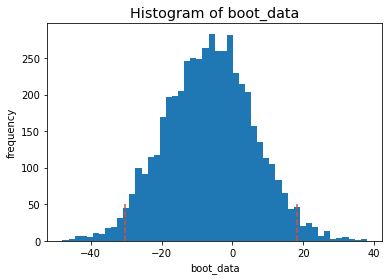

In [45]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

In [46]:
#aov
sample1 = df[df['group'] == 'control'].aov
sample2 = df[df['group'] == 'variant'].aov

  0%|          | 0/5000 [00:00<?, ?it/s]

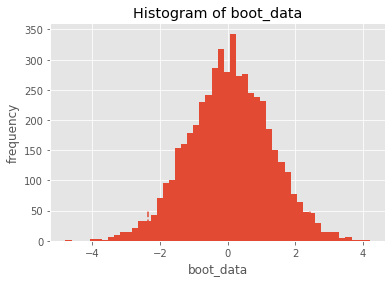

In [47]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

In [54]:
#spent
sample1 = df[df['group'] == 'control'].purchases
sample2 = df[df['group'] == 'variant'].purchases

  0%|          | 0/5000 [00:00<?, ?it/s]

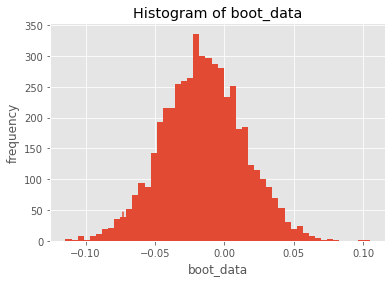

In [55]:
booted_data = get_bootstrap(sample1, sample2, boot_it = 5000, statistic=np.mean)

We cannot reject $H_0$ for any metrics